# Test Functional Coherence of GO Terms in Clusters

In [7]:
# Initial Files
cluster_file_path = "/data/cb/samsl/philharmonic/20240913_philharmonic_pdam/20240913_pdam_clusters.recipe.json"
network_file_path = "/data/cb/samsl/philharmonic/20240913_philharmonic_pdam/20240913_pdam_network.positive.tsv"
go_map_path = "/data/cb/samsl/philharmonic/20240913_philharmonic_pdam/20240913_pdam_GO_map.csv"

GO_SLIM = "/data/cb/samsl/philharmonic/20240913_philharmonic_pdam/goslim_generic.obo"
GO_SLIM = "/data/cb/samsl/philharmonic/20240913_philharmonic_pdam/goslim_generic.obo"

---

In [52]:
import numpy as np
from utils import Cluster, parse_GO_map, parse_GO_database, load_cluster_json, clean_top_terms
from scipy.spatial.distance import jaccard
from sklearn.metrics import jaccard_score
from itertools import combinations
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
# Load clusters
cluster_dict = load_cluster_json(cluster_file_path)
clusters = [Cluster(i) for i in cluster_dict.values()]

In [9]:
# Add GO Annotations
go_map = parse_GO_map(go_map_path)
go_db = parse_GO_database(GO_SLIM)

In [10]:
for clust in clusters:
    clust.add_GO_terms(go_map, go_db)
    for gt in clust.GO_terms.keys(): assert gt in go_db.keys()

---

## Native Cluster Coherence

In [29]:
def protein_GO_bit_vector(protein_id, go_map, full_go_list,id_col='seq',go_col='GO_ids'):
    go_bv = np.zeros(len(full_go_list))
    prot_go = go_map.get(protein_id)
    if prot_go is not None:
        for gid in prot_go:
            if gid in full_go_list:
                go_bv[full_go_list.index(gid)] = 1
    return go_bv

In [20]:
go_assigned = set()
for c in tqdm(clusters):
    for g in c.GO_terms.keys():
        go_assigned.add(g)
go_assigned = sorted(list(go_assigned))
len(go_assigned)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 532/532 [00:00<00:00, 280463.77it/s]


28

In [16]:
proteins_in_clusters = []
for c in tqdm(clusters):
    proteins_in_clusters.extend(c.members)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 532/532 [00:00<00:00, 491816.12it/s]


In [17]:
len(proteins_in_clusters)

8500

In [54]:
protein_GO_bvs = {}
for pid in proteins_in_clusters:
    protein_GO_bvs[pid] = protein_GO_bit_vector(pid, go_map, go_assigned)

cluster_jaccards = {}

for c in clusters:
    cjaccard = []
    for (p1, p2) in combinations(c.members, 2):
        jc = 1 - jaccard(protein_GO_bvs[p1], protein_GO_bvs[p2])
        cjaccard.append(jc)
    cluster_jaccards[hash(c)] = np.array(cjaccard)

---

## Shuffled Cluster Coherence

In [43]:
rng = np.random.default_rng(seed=42)
shuffled_keys = rng.permutation(list(go_map.keys()))
shuffled_go_map = {k: v for k,v in zip(shuffled_keys, go_map.values())}

In [55]:
protein_GO_bvs_perm = {}
for pid in proteins_in_clusters:
    protein_GO_bvs_perm[pid] = protein_GO_bit_vector(pid, shuffled_go_map, go_assigned)

cluster_jaccards_perm = {}

for c in clusters:
    cjaccard = []
    for (p1, p2) in combinations(c.members, 2):
        jc = 1 - jaccard(protein_GO_bvs_perm[p1], protein_GO_bvs_perm[p2])
        cjaccard.append(jc)
    cluster_jaccards_perm[hash(c)] = np.array(cjaccard)

--- 
## Compare

In [47]:
from scipy.stats import ttest_ind
def one_tail_ttest(null, greater):
    tstat, p = ttest_ind(null, greater)
    if tstat > 0:
        return tstat, (1-(p/2))
    else:
        return tstat, p/2

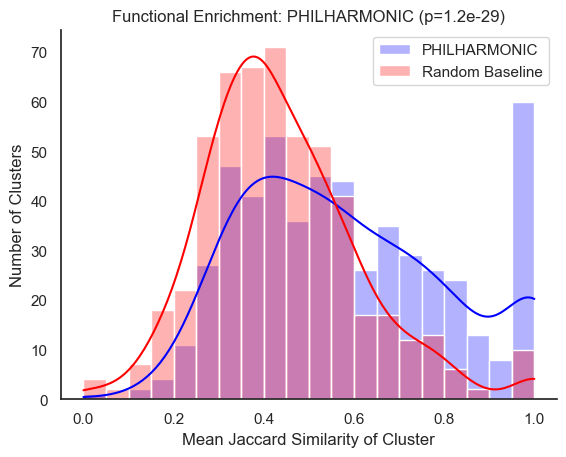

In [57]:
sns.set_palette("colorblind")
sns.set(style="white", font_scale=1)
kde = True

phil_mean = [i.mean() for i in cluster_jaccards.values()]
permute_mean = [i.mean() for i in cluster_jaccards_perm.values()]

sns.histplot( phil_mean , color="blue", label="PHILHARMONIC", bins=np.arange(0,1.05,0.05), alpha=0.3, kde=True)
sns.histplot( permute_mean , color="red", label="Random Baseline", bins=np.arange(0,1.05,0.05), alpha=0.3, kde=True)
tstat, p = one_tail_ttest(permute_mean, phil_mean)

plt.title("Functional Enrichment: PHILHARMONIC (p={:.3})".format(p))
plt.xlabel("Mean Jaccard Similarity of Cluster")
plt.ylabel("Number of Clusters")
plt.legend()
sns.despine()
# plt.savefig(f"{OUTPUT_DIR}{net_name}.func_enrichment.png",bbox_inches='tight',dpi=300,transparent=True)
plt.show()

---
## Display Coherence by GO Slim Function

In [58]:
cluster_top_terms = {hash(c): clean_top_terms(c, go_db, return_counts=False) for c in clusters}

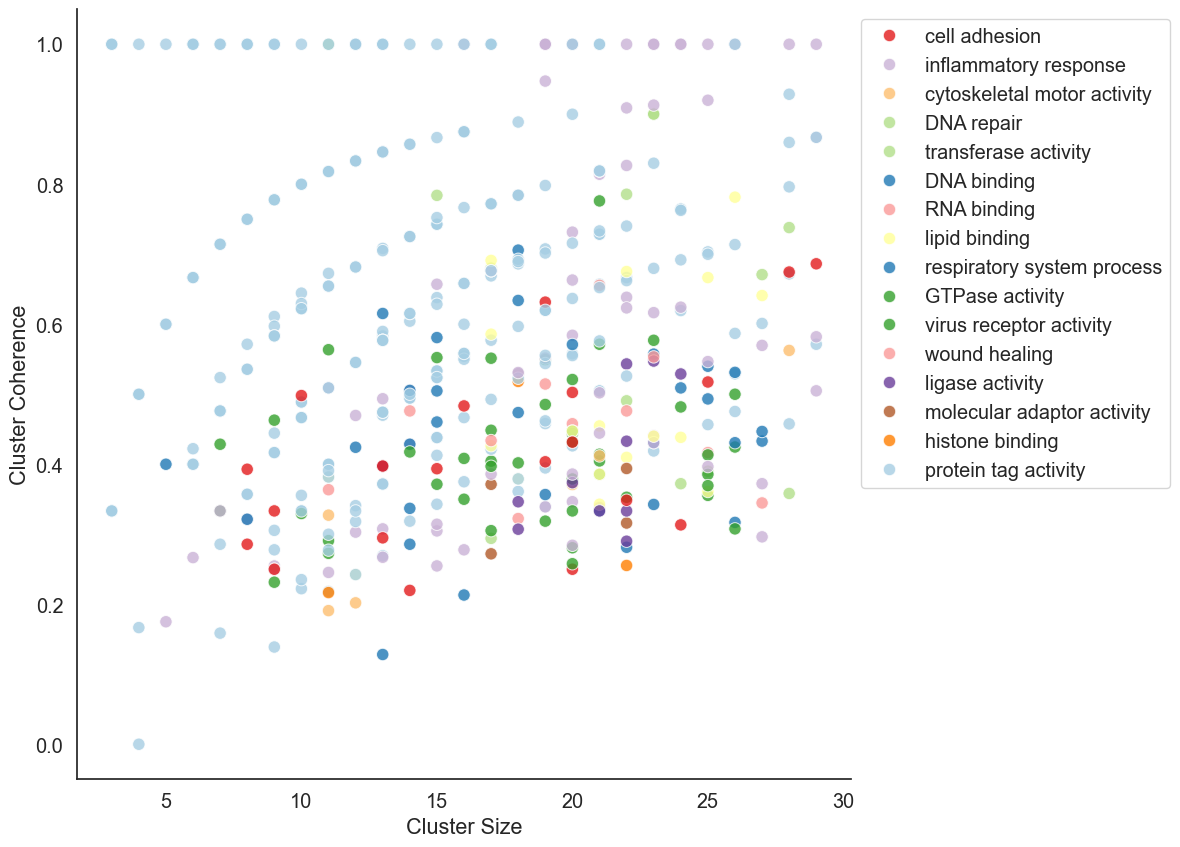

In [59]:
sns.set(style='white', font_scale=1.3)
fig,ax = plt.subplots(figsize=(10,10))

clens = [len(c) for c in clusters]
cjacc = [np.mean(cluster_jaccards[hash(c)]) for c in clusters]
cfunc = [cluster_top_terms[hash(c)] for c in clusters]
color_map = {k:v for k,v in zip(sorted(set(cfunc)), sns.color_palette("Paired", len(set(cfunc))))}
color_map["No function"] = (0.8,0.8,0.8)

sns.scatterplot(x=clens, y=cjacc, s=80, alpha=0.8, hue=cfunc, palette=color_map, ax=ax)
plt.xlabel('Cluster Size')
plt.ylabel('Cluster Coherence')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
sns.despine()
plt.show()